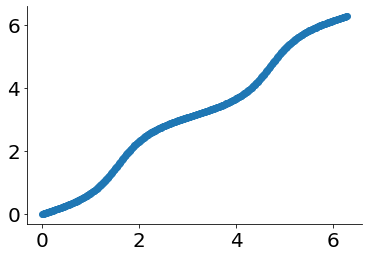

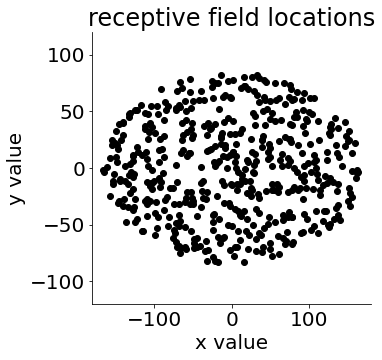

(500, 500)


In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
matplotlib.rcParams['pdf.fonttype'] = 42
np.random.seed(1)

### set some parameters ###
N = 500 #number of neurons in each layer

#### 'receptive field' neurons ####
# generate random receptive fields
R = 1.2 #cover a space of radius R
r = R * np.sqrt(np.random.uniform(1e-3, 1, N)) #receptive field distance from center
theta_r = np.sort(np.linspace(np.pi/N, 2*np.pi*(1-0.5/N), N)) #receptive field angle
locs = np.array([r * np.cos(theta_r), r * np.sin(theta_r)]) #transform RF center to Cartesian coordinates
locs *= np.array([1, 0.5])[:, None] #scale to visual fields
locsN = locs / np.sqrt(np.sum(locs**2, axis = 0, keepdims = True))
theta_r_new = (np.sign(locsN[1, :])*np.arccos(locsN[0, :])+2*np.pi) % (2*np.pi)
plt.figure()
plt.scatter(theta_r, theta_r_new)
plt.show()
theta_r = theta_r_new
kappa = 40 #how concentrated are our receptive fields (1/std^2)
scale = 140 #degrees per unit

#plot RF centers
plt.figure(figsize = (5,5))
plt.scatter(locs[0, :]*scale, locs[1, :]*scale, color = 'k')
plt.xlabel('x value')
plt.ylabel('y value')
plt.title('receptive field locations')
plt.ylim(-120, 120)
plt.xlim(-180, 180)
plt.savefig("RF.pdf")
plt.show()
plt.close()

#### generate direction selective neurons ###
theta_d = theta_r+np.pi #respond to motion opposite location

### generate motor neurons ###
theta_m = theta_d - np.pi #move opposite direction of motion
locs_m = np.array([np.cos(theta_m),np.sin(theta_m)]) #compute velocity induced by each motor neuron in (x,y) coordinates

### generate connectivities ###
W_rd = np.eye(N) #concentricity; connect to neurons of same 'direction'
W_dm = np.eye(N) #connect DS and motor neurons

print(W_rd.shape)


In [ ]:
def normalize(v):
  '''function for normalizing a vector v'''
  return v / np.sqrt(np.sum(np.array(v)**2))

In [ ]:
### run actual continuous-time dynamics ###

def phi(x): #transfer function (relu neurons)
  return np.maximum(x, 0)

def run_sim(loc0, vel, rel_speed= 1, tau_move = 500, tau = 20, tau_stim = 5000, conc = False, shift = 0, T = 5000, sig = 1e-1):
  '''
  function for running a full simulation of an agent 'tracking' an object.
  We assume an initial object position (in egocentric coordinates) and a constant object velocity.
  We also need to make an assumption about how large our maximum speed is relative to the speed of the object.
  The result of this simulation will be a series of agent movement speeds, object positions (in egocentric space), and neural activations.
  We can run the simulation with either the concentric or retinotopic model and arbitrary
  offset/shift from 'anti-alignment' between sensory and motor tuning.


  the simulation continues until the object is outside the [0,1] range along the x or y axis
  everything is measured in egocentric coordinates

  inputs
  loc0: the initial position of the object (2d vector)
  vel: object velocity (2d vector)
  rel_speed: how fast self-motion is compared to stimulus motion
  tau: timescale of neural activity
  tau_move: timescale of movement # 500
  tau_stim: timescale of stimulus movement # 5000
  T: maximum number of iterations before we terminate simulation
  sig: noise level

  returns
  locs: Tx2 array of object locations relative to self
  vels: Tx2 array of self motion velocities
  xs_r: TxN array of retinotopic neural activity
  xs_d: TxN array of DS neural activity
  xs_m: TxN array of motor neuron activity
  ts: timepoints

  1 unit = 140 degrees = edge of horizontal visual field
  0.5 units = 70 degrees = edge of vertical visual field
  '''

  #rename some variables for legacy reasons
  stim, stim_vel = np.array(loc0), np.array(vel)
  norm_vel = normalize(stim_vel)
  tau_move /= rel_speed #scale movement speed by 'rel_speed'

  stims = [stim] # list of stimulus locations over time (egocentric)
  ag_locs = [ np.zeros(2) ] #list of agent locations over time (allocentric)
  vels = [0] # velocities over time
  obj_vels = [np.sqrt(np.sum((stim_vel/tau_stim)**2))]
  ts = [0] #timepoints simulated

  #initialize lists for storing neural activity over time in all three layers
  xs_r, xs_m, xs_d = [np.zeros(N)], [np.zeros(N)], [np.zeros(N)]

  n = 0
  #continue simulating while in the relevant quadrant
  cond_rel, cond_loc = True, True
  while cond_rel and cond_loc and (n < T):
    n += 1 #current timestep
    ts.append(n)
    stim_loc = stims[-1] #current stimulus location
    stim_dir = np.arctan2(stim_loc[1], stim_loc[0]) #angle of stimulus location
    if conc: #concentric; scale by overlap
      norm_loc = normalize(stim_loc) #normalized vectors
      conc_component = max(0, np.dot(norm_vel, -norm_loc)) #concentric component (overlap between normalized velocity and location)
      stim_dists = (np.cos(np.pi+stim_dir-theta_d)-1) #distance to preferred orientation
      dir_input = np.exp(kappa*stim_dists) #input to direction selective cells (von mises tuning)
      xs_r.append(np.zeros(N)) #receptive field neurons are silent
    else: #retinotopic
      stim_dists = np.sum(((locs - stims[-1][:, None])*np.array([1, 1])[:, None])**2, axis = 0) #distance to preferred locations
      #update receptive field activity
      xs_r.append(phi(xs_r[-1] + 1/tau * ( -xs_r[-1] + 1.5*np.exp( -1.2*kappa * stim_dists/2 ) + np.random.normal(0, sig, N) ) ))
      #input to DS neurons
      dir_input = W_rd @ xs_r[-1]
      #in this case the concentric component is taken to be 1
      conc_component = 1.0

    #scale by concentric component and normalize
    dir_input *= conc_component*35/np.sum(dir_input)
    if shift > 0: #allow for a shift away from anti-alignment
      dir_input = np.roll(dir_input, int(np.round(shift/(2*np.pi)*N))) #circshift neural activity (since preferred orientations are ordered)

    #update direction selective neurons
    xs_d.append(phi( xs_d[-1] + 1/tau * ( -xs_d[-1] + dir_input + np.random.normal(0, sig, N) ) ))
    #update movement selective neurons
    xs_m.append(phi( xs_m[-1] + 1/tau * ( -xs_m[-1] + W_dm @ xs_d[-1] + np.random.normal(0, sig, N) ) ))

    d_stim = xs_m[-1][None, :] * locs_m #attempted movement for each neuron
    d_stim = np.mean(d_stim, axis = 1)/tau_move #mean across neurons, normalized by movement timescale
    vels.append(np.sqrt(np.sum(d_stim**2))) #instantaneous velocity
    ag_locs.append(ag_locs[-1] + d_stim) #agent location

    stims.append(stims[-1] - d_stim) #update stimulus location due to self motion (in egocentric space)
    stims[-1] += stim_vel/tau_stim #movement of the stimulus itself
    obj_vels.append(np.sqrt(np.sum((stim_vel/tau_stim)**2)))

    cond_rel = (np.amin(stims[-1]) >= -0.01) and (stims[-1][0] < 1) and (stims[-1][1] < 0.5) #in receptive field
    cond_loc = (ag_locs[-1][0] < 200/scale) and (ag_locs[-1][1] < 100/scale) #within motor domain

  #turn everything into numpy arrays
  tscale = 0.5
  xs_r, xs_d, xs_m, stims, vels, ag_locs, obj_vels = [np.array(a) for a in [xs_r, xs_d, xs_m, stims, vels, ag_locs, obj_vels]]
  ts = np.array(ts)*tscale #1 timestep is 0.5 ms

  #vels is degrees per second
  return stims*scale, 1e3*vels*scale/tscale, xs_r, xs_d, xs_m, ts, ag_locs*scale, 1e3*obj_vels*scale/tscale



[-0.001 -0.001]


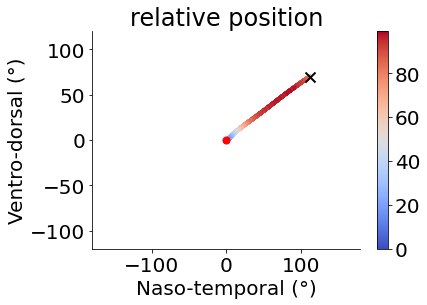

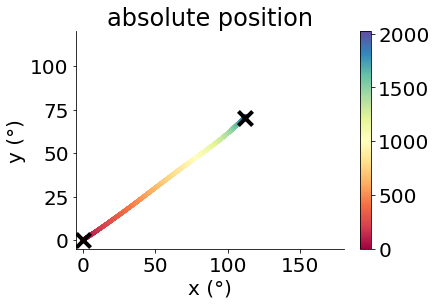

In [ ]:
### check that things work ###

loc0 = np.array([0.8,0.5]) #initial stimulus. 0.8, 0.5
vel = np.array([-0.001,-0.001])#np.array([-1,-0.5]) #velocity of object
print(vel)

#run simulation
new_locs, vels, xs_r, xs_d, xs_m, ts, ag_locs, obj_vels = run_sim(loc0, vel, conc = False, rel_speed = 3)
#print(np.amin(new_locs/scale))
#print(np.amax(vels), np.amax(obj_vels))

### plot 2d trajectory
n=1
vec1=new_locs[:,0]
vec2=new_locs[:,1]
#print(vec2.shape)
#print(vels.shape, new_locs.shape)
plt.figure()
plt.scatter(vec1[::n], vec2[::n], c = vels[::n], s = 10,  cmap = 'coolwarm')
plt.colorbar()
plt.scatter([new_locs[0, 0]], [new_locs[0,1]], c = 'k', marker = 'x', s = 100, lw = 2)
plt.scatter([0], [0], c = 'r', marker = 'o', s = 50)
plt.xlabel('Naso-temporal (°)')
plt.ylabel('Ventro-dorsal (°)')
plt.ylim(-120, 120)
plt.xlim(-180, 180)
#plt.ylim(-1, 1)
#plt.xlim(-1, 1)
#plt.xticks([])
#plt.yticks([])
plt.title('relative position')
plt.savefig("rel_Stat.pdf")
plt.show()

obj_locs = ag_locs+new_locs
plt.figure()
vec1=ag_locs[:,0]
vec2=ag_locs[:,1]
vec3=obj_locs[:,0]
vec4=obj_locs[:,1]
plt.scatter(vec1[::n], vec2[::n], c = ts[::n], s = 10, cmap = 'Spectral')
plt.scatter(vec3[::n], vec4[::n], c = ts[::n], s = 10, cmap = 'Spectral')
plt.colorbar()
plt.scatter([ag_locs[0,0], obj_locs[0,0]], [ag_locs[0,1], obj_locs[0,1]], marker = 'x', c = 'k', s = 200, lw = 4)
#plt.plot([ag_locs[0,0], obj_locs[0,0]], [ag_locs[0,1], obj_locs[0,1]], 'k--')
plt.xlabel('x (°)')
plt.ylabel('y (°)')
plt.ylim(-5, 120)
plt.xlim(-5, 180)

plt.title('absolute position')
plt.savefig("abs_Stat.pdf")
plt.show()

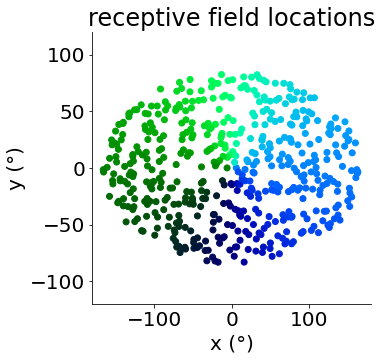

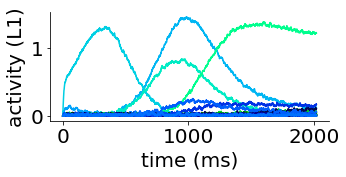

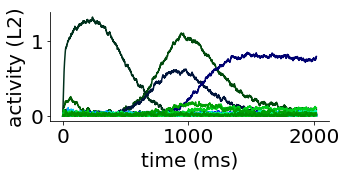

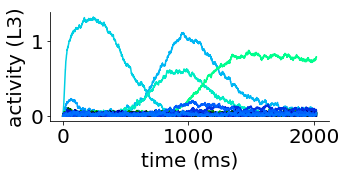

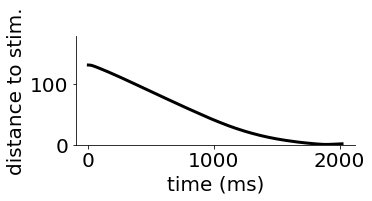

In [ ]:
## plot neural activities

cols_r = [[0, 0.5+0.5*np.sin(theta_r[n]), 0.5+0.5*np.cos(theta_r[n])] for n in range(N)]
cols_d = [[0, 0.5+0.5*np.sin(theta_d[n]), 0.5+0.5*np.cos(theta_d[n])] for n in range(N)]
cols_m = [[0, 0.5+0.5*np.sin(theta_m[n]), 0.5+0.5*np.cos(theta_m[n])] for n in range(N)]


#print(cols_r)
plt.figure(figsize = (5,5))
plt.scatter(locs[0, :]*scale, locs[1, :]*scale, color = cols_r)
plt.xlabel('x (°)')
plt.ylabel('y (°)')
plt.title('receptive field locations')
plt.ylim(-120, 120)
plt.xlim(-180, 180)
matplotlib.rcParams['pdf.fonttype'] = 42
plt.savefig("RF.pdf")
plt.show()
plt.close()


### activity of receptive field neurons (zero if concentric)
plt.figure(figsize = (5,2))
for i in range(0, N, 20):
  plt.plot(ts, xs_r[:,i], color = cols_r[i])
plt.xlabel('time (ms)')
plt.ylabel('activity (L1)')
#plt.xlim(0, 2500)
plt.savefig("L1_stat.pdf")
plt.show()

#activity of DS neurons
plt.figure(figsize = (5,2))
for i in range(0, N, 20):
  plt.plot(ts, xs_d[:,i], color = cols_d[i])
plt.xlabel('time (ms)')
plt.ylabel('activity (L2)')
#plt.xlim(0, 20)
plt.savefig("L2_stat.pdf")
plt.show()

#activity of motor neurons
plt.figure(figsize = (5,2))
for i in range(0, N, 20):
  plt.plot(ts, xs_m[:,i], color = cols_m[i])
plt.xlabel('time (ms)')
plt.ylabel('activity (L3)')
#plt.xlim(0, 2500)
plt.savefig("L3_stat.pdf")
plt.show()

#distance to stimulus from center over time
plt.figure(figsize = (5,2))
plt.plot(ts, np.sqrt(np.sum(new_locs**2, axis = 1)), 'k-', lw = 3)
plt.xlabel('time (ms)')
plt.ylabel('distance to stim.')
#plt.ylim(0, 1.01)
plt.ylim(0, 180)
#plt.xlim(0, 20)
plt.savefig("Time_stat.pdf")
plt.show()


KeyboardInterrupt: ignored

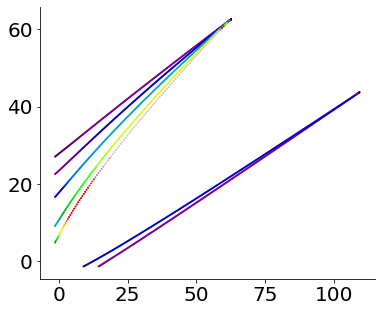

In [ ]:
### run simulations for different relative movement speeds ###
### here, relative movement speed specifies the balance between object motion and agent motion ###

vel = [-1, -0.5] #velocity of object
rel_speeds = 10**np.linspace(-1, 1, 15) #relative movement speed of us vs object np.linspace(0, 10, 200)#
#print(rel_speeds)
test_locs = [normalize([1, 2]), normalize([1,0.8]), normalize([1, 0.2])] #object initial locations
rel_colour=[]

rel_speeds = [0.2, 0.5, 1, 2, 3]

plt.figure(figsize = (6,5))
for loc in test_locs: #walk through initial object locations
  loc *= np.array([1, 0.5])
  for rel_speed in rel_speeds:
    #print(loc, tau_move)
    new_locs, move_vels, _, _, _, _, _, _ = run_sim(loc, vel, rel_speed = rel_speed, conc = True, shift = 0) #run simulation (conc = True/False indicates concentric/retinotopic)
    n=10
    vec1=new_locs[:,0]
    vec2=new_locs[:,1]
    plt.scatter(vec1[::n], vec2[::n], cmap = 'nipy_spectral', c = move_vels[::n], s = 1, vmin = 0, vmax = 100) # to plot speed of reach

#set plot settings
#plt.xlim(-0.0, 1)
#plt.ylim(-0.0, 1)
plt.xlabel('x position')
plt.ylabel('y position')
plt.colorbar()
plt.show()

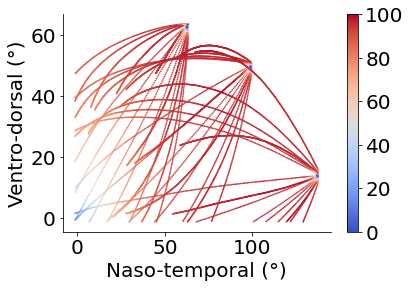

In [ ]:
vec_vel = [[0,1], [0.5, 1],[1,1],[1,0.5],[1, 0],[1, -0.5],[1,-1],[0.5, -1],[0,-1],[-0.5,-1],[-1,-1],[-1, -0.5],[-1,0],[-0.5, 1],[-1,1]]
vec_angs = np.linspace(0, 2*np.pi, 15)
rel_speed = 3
vec_ang= 0
test_locs = [normalize([1,2]), normalize([1,1]), normalize([0.5, 0.1])] #object initial locations
vel_colour=[]
i=0

#plt.figure(figsize = (6,5))
for loc in test_locs: #walk through initial object locations
  loc *= np.array([1, 0.5])
  i=0
  for vel in vec_vel: #walk through relative movement speeds
    #print(vel)
    new_locs, move_vels, _, _, _, _, _, _ = run_sim(loc, vel, rel_speed, conc = False, shift = 0) #run simulation (conc = True/False indicates concentric/retinotopic)
    vec_ang= vec_angs[i]
    i+=1
    vel_colour=[vec_ang]*len(move_vels)
    #plot
    #plot result = colou indicates speed of self-motion
    n=10
    vec1=new_locs[:,0]
    vec2=new_locs[:,1]
    plt.scatter(vec1[::n], vec2[::n], cmap = 'coolwarm', c = move_vels[::n], s = 0.3, vmin = 0, vmax = 100)
    #plt.scatter(new_locs[:, 0], locs[:, 1], cmap = 'rainbow', c = vel_colour, s = 3, vmin = 0, vmax = 6.3) # to identify shift
#set plot settings
#plt.xlim(-0.0, 1)
#plt.ylim(-0.0, 1)
plt.xlabel('Naso-temporal (°)')
plt.ylabel('Ventro-dorsal (°)')
plt.colorbar()
plt.savefig("Simulation_con.pdf")
plt.show()
plt.close()


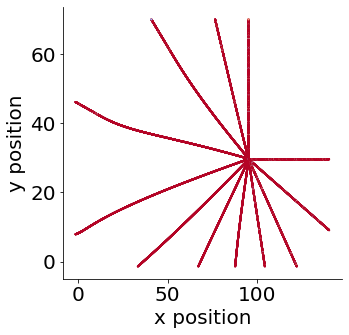

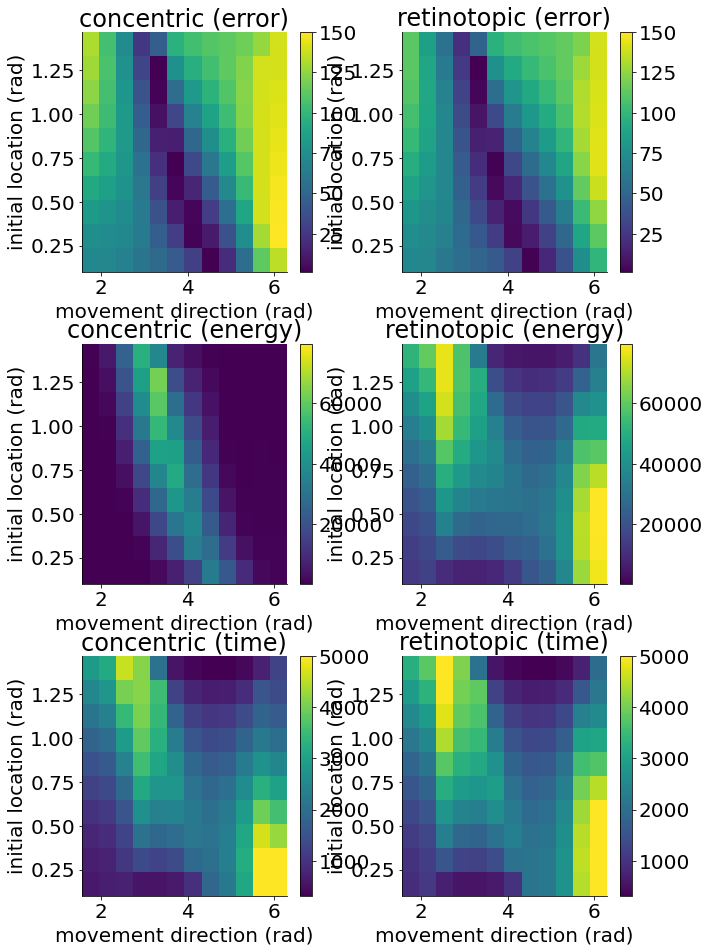

In [ ]:
### now try to quantify performance as a function of start position and movement direction ###

def quantify_perf(theta_locs, theta_vels, rel_speed, Plot = False, shift = 0):
  '''
  function for quantifying the 'performance' of our model under different conditions.
  here, we consider different initial object locations and different object velocities.
  We then run a full simulation for each object location/velocity and quantify our performance for this simulation.
  We compute three measures of 'performance', name the final error (distance from agent),
  the energy expenditure (integrated speed), and the time of the simulation.

  inputs
  theta_locs: initial object locations, meaured in radians (assume initial distance of 0.8)
  theta_vels: object movement vectors, measured in radians (assume speed of 0.8)
  rel_speed: relative magnitude of maximum self motion speed and object speed
  shift: the shift away from anti-alignment

  outputs
  final_errs: the distance from self at the end of each simulation (i.e. when the object left the [0,1] range)
  final_ens: the total energy expenditure, defined as the integrated self motion speed, for each simulation
  final_ts: the total time of each simulation (in timesteps)
  '''

  #initialize arrays for results
  final_errs = np.zeros((2, len(theta_locs), len(theta_vels)))
  final_ens = np.zeros((2, len(theta_locs), len(theta_vels)))
  final_ts = np.zeros((2, len(theta_locs), len(theta_vels)))

  if Plot: plt.figure(figsize = (5,5)) #optional plotting

  for iloc, theta_loc in enumerate(theta_locs): #for each initial location
    loc = 0.8*np.array([np.cos(theta_loc), np.sin(theta_loc)]) #initialize object location in Cartesian coordinates
    loc *= np.array([1, 0.5])
    for ivel, theta_vel in enumerate(theta_vels): #for each object velocity
      vel = 0.8*np.array([np.cos(theta_vel), np.sin(theta_vel)]) #initialize object velocity in Cartesian coordinates

      new_locs, move_vels, _, _, _, _, _, _ = run_sim(loc, vel, rel_speed = rel_speed, conc = True) #run concentric simulation
      err = np.sqrt(np.sum(np.array(new_locs[-1])**2)) #error is distance from origin at the end of simulation
      final_errs[0, iloc, ivel] = err #store error
      final_ens[0, iloc, ivel] = np.sum(move_vels[:-1]) #energy is integrated movement speed
      final_ts[0, iloc, ivel] = len(new_locs) #time is total simulation duration

      #optionally plot result
      if Plot and (iloc == 3): plt.scatter(new_locs[:, 0], new_locs[:, 1], cmap = 'coolwarm', c = move_vels, s = 1, vmin = 0, vmax = 0.04)

      new_locs, move_vels, _, _, _, ts, _, _ = run_sim(loc, vel, rel_speed = rel_speed, conc = False, shift = shift) #run retinotopic simulation
      err = np.sqrt(np.sum(np.array(new_locs[-1])**2)) #error
      final_errs[1, iloc, ivel] = err #store
      final_ens[1, iloc, ivel] = np.sum(move_vels[:-1]) #energy
      #try to compute 'real' energy required to move the head
      accs = (move_vels[1:-1] - move_vels[:-2])/(ts[1:-1] - ts[:-2])*1e3 * np.pi/180 #acceleration (radians / s^2)
      m, r = 6*1e-3, 2.5*1e-2 #mass (6g) and radius (2.5cm)
      moment_of_inertia = 2/5 * m * r**2 #kg*m^2
      energy = np.sum(moment_of_inertia*np.abs(accs)) #kg*m^2*radians/s^2 = J*radians
      final_ts[1, iloc, ivel] = len(new_locs) #duration

  if Plot: #optionally set plotting parameters
    #plt.xlim(-0.0, 1)
    #plt.ylim(-0.0, 1)
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.show()

  #return results
  return final_errs, final_ens, final_ts

#consider object locations from 0 to pi/2
theta_locs = np.linspace(0.1, 0.5*np.pi-0.1, 10)

#consider movement directions from pi/2 to 2*pi: only take out completely excentric movements
theta_vels = np.linspace(0.5*np.pi, 2*np.pi, 12)

for rel_speed in [0.5]:#, 1.0, 3.0]: #consider different self motion speeds 0.5, 1.0, 3.0
  #can set 'shift' to different values to apply a shift between sensory and motor neurons (in radians)
  final_errs, final_ens, final_ts = quantify_perf(theta_locs, theta_vels, rel_speed, Plot = True, shift = 0)

  #set some figure parameters
  fig = plt.figure(figsize = (8, 12))
  gs = fig.add_gridspec(3,2, left=0, right=1, bottom=0.0, top=1., wspace = 0.25, hspace = 0.3)
  extent = (theta_vels[0], theta_vels[-1], theta_locs[0], theta_locs[-1])
  dats = [final_errs, final_ens, final_ts]
  for i1, dat in enumerate(dats): #plot both errors, energies and durations
    for i2 in range(2): #consider both retinotopic (left) and concentric (right)
      ax = fig.add_subplot(gs[i1, i2])
      #plot heatmap
      im1= ax.imshow(dat[i2, ...], cmap = 'viridis', vmin = np.amin(dat), vmax = np.amax(dat),extent = extent, aspect = 'auto')
      #add some labels
      cbar1 = fig.colorbar(im1, ax=ax)
      ax.set_xlabel('movement direction (rad)')
      ax.set_ylabel('initial location (rad)')
      ax.set_title(['concentric', 'retinotopic'][i2]+' ('+['error', 'energy', 'time'][i1]+')')
  plt.savefig("ErrorEnergy_2.svg")
  plt.show()

### first set of plots is not moving at all, second is slower than the object, third is faster

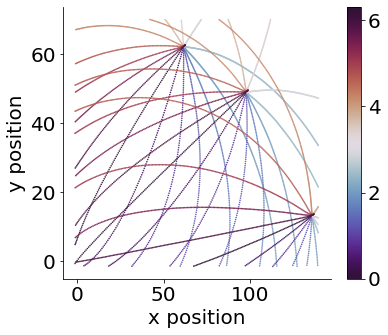

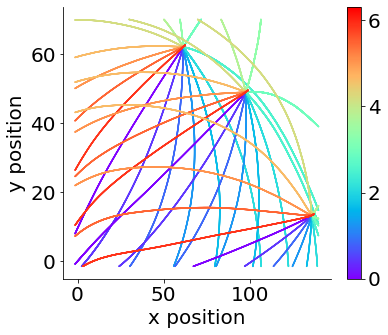

In [ ]:
### here we look at the effect of shifting the mapping between sensory and motor ###

vel, rel_speed = [-1, -0.5], 3 #object velocity and own relative velocity
test_locs = [normalize([1, 2]), normalize([1,1]), normalize([1, 0.2])] #initial object locations
shifts = np.linspace(0, 2*np.pi-np.pi/8, 15)*1 #consider shifts around the circle
shift_colour=[]

plt.figure(figsize = (6,5))
for loc in test_locs: #for each object location
  loc *= np.array([1, 0.5])
  for shift in shifts: #for each shift
    new_locs, move_vels, _, _, _, _, _, _ = run_sim(loc, vel, rel_speed = rel_speed, conc = True, shift = shift) #run simulation
    shift_colour=[shift]*len(move_vels)
    #plot result
    #plt.scatter(new_locs[:, 0], new_locs[:, 1], cmap = 'rainbow', c = shift_colour, s = 0.2, vmin = 0, vmax = 6.3) # to identify shift
    n=10
    vec1=new_locs[:,0]
    vec2=new_locs[:,1]
    plt.scatter(vec1[::n], vec2[::n], cmap = 'twilight_shifted', c = shift_colour[::n], s = 0.3, vmin = 0, vmax = 6.3)

#plt.xlim(-0.0, 1)
#plt.ylim(-0.0, 1)
plt.xlabel('x position')
plt.ylabel('y position')
plt.colorbar()
plt.savefig("Shift.pdf")
plt.show()

plt.figure(figsize = (6,5))
for loc in test_locs: #for each object location
  for shift in shifts: #for each shift
    new_locs, move_vels, _, _, _, _, _, _ = run_sim(loc, vel, rel_speed = rel_speed, conc = False, shift = shift) #run simulation
    shift_colour=[shift]*len(move_vels)
    #plot result
    plt.scatter(new_locs[:, 0], new_locs[:, 1], cmap = 'rainbow', c = shift_colour, s = 0.2, vmin = 0, vmax = 6.3) # to identify shift

#plt.xlim(-0.0, 1)
#plt.ylim(-0.0, 1)
plt.xlabel('x position')
plt.ylabel('y position')
plt.colorbar()

plt.show()

In [ ]:
### here we run simulations for a range of different relative movement speeds ###

theta_locs = np.linspace(0.1, 0.5*np.pi-0.1, 10) #initial object locations
theta_vels = np.linspace(0.5*np.pi, 2*np.pi, 15) #object movement directions: only exclude one quadrant of completely excentric
#theta_vels = np.linspace(1.0*np.pi,1.5*np.pi, 10) #object movement directions: only consider quadrant of completely concentric

rel_speeds = np.linspace(0, 6, 40) #relative speeds to consider
#initialize arrays for storing errors and energies
all_errs, all_ens = [np.zeros((len(rel_speeds), 2, len(theta_locs), len(theta_vels))) for _ in range(2)]

for itau, rel_speed in enumerate(rel_speeds): #for each movement speed
  #run simulation
  final_errs, final_ens, final_ts = quantify_perf(theta_locs, theta_vels, rel_speed+1e-6, Plot = False)
  all_errs[itau, ...] = final_errs #store error
  all_ens[itau, ...] = final_ens #store energy

  if itau % 3 == 0: #occasionally print progress
    print('\nnew tau:', rel_speed)
    print(np.mean(final_errs, axis = (1,2)))
    print(np.mean(final_ens, axis = (1,2)))
print('finished')


new tau: 0.0
[82.30956316 82.30954293]
[0.02744025 0.06866535]

new tau: 0.46153846153846156
[79.2742065  71.74271756]
[10991.65711288 32090.08335076]

new tau: 0.9230769230769231
[76.84605301 60.57862961]
[19520.18051292 65000.20721632]

new tau: 1.3846153846153846
[74.86428029 49.24199963]
[26373.04483029 98877.24336741]

new tau: 1.8461538461538463
[73.26828277 39.39012547]
[ 31964.38182821 117254.53006542]

new tau: 2.307692307692308
[71.87520194 32.50734539]
[ 36726.37227001 129189.9543482 ]

new tau: 2.769230769230769
[70.70061218 27.77298331]
[ 40806.93076004 137392.71628847]

new tau: 3.230769230769231
[69.69720939 24.42210879]
[ 44273.28222816 143038.95907749]

new tau: 3.6923076923076925
[68.81888331 21.83291753]
[ 47360.31662418 145435.77376473]

new tau: 4.153846153846154
[68.02290542 19.79644976]
[ 50146.20134485 146412.67400377]

new tau: 4.615384615384616
[67.27408401 18.06265358]
[ 52701.32185724 147358.90905666]

new tau: 5.0769230769230775
[66.6495576  16.62001717]
[

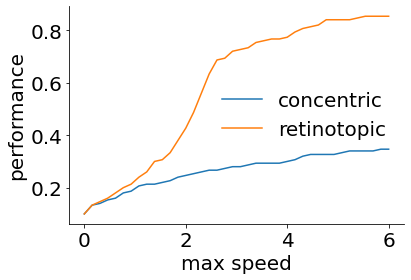

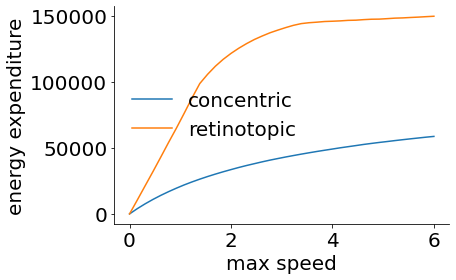

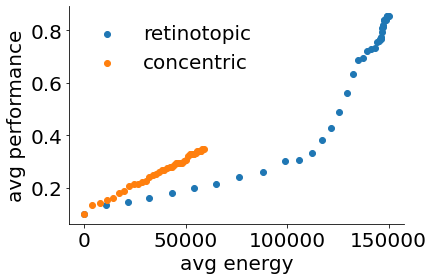

finished


In [ ]:
### here we plot some results ###

thresh = 0.2*scale #threshold for when we consider a simulation 'successful'; i.e. successful simulations have errors less than thresh

mean_errs = np.mean(all_errs, axis = (-1, -2)) #(this is if we want to plot raw/average error)
mean_errs = np.mean(all_errs < thresh, axis = (-1, -2)) #consider success rate (average over simulations)
mean_ens = np.mean(all_ens, axis = (-1, -2)) #consider energy (average over simulations)

### plot success rate vs movement speed ###
plt.figure()
plt.plot(rel_speeds, mean_errs)
plt.legend(['concentric', 'retinotopic'], frameon = False)
plt.xlabel('max speed')
plt.ylabel('performance')
#plt.ylim( [ 0, 1 ] )
plt.savefig("Performance_all.svg")
plt.show()

### plot energy expenditure vs movement speed ###
plt.figure()
plt.plot(rel_speeds, mean_ens)
plt.legend(['concentric', 'retinotopic'], frameon = False)
plt.xlabel('max speed')
plt.ylabel('energy expenditure')
plt.savefig("Energy_all.svg")
plt.show()

### plot success rate vs energy expenditure ###
plt.figure()
plt.scatter(mean_ens[:,1],mean_errs[:, 1])
plt.scatter(mean_ens[:, 0],mean_errs[:, 0])
plt.legend(['retinotopic', 'concentric'], frameon = False)
plt.xlabel('avg energy')
plt.ylabel('avg performance')
plt.savefig("Performance_energy_all_rev.svg")
#plt.ylim( [ 0, 1 ] )
plt.show()
print('finished')